<h2> Visualizing Model Results

A key component of testing machine learning models during the dev/test and production phase is to plot model metrics. 

For supervised classification/regression models such as Linear Learner, Random Forest, XGBoost, even deep learning models, one often wants to compare the performance of different models relative to one another. Metrics such as Accuracy are only helpful up to a point; in real world environments, often the precision, recall, confusion matrix, ROC curves yield more actionable information. 

Feature importances are also often needed by the business to get insights into what features the model is picking to make predictions. Identifying the most important features for example can help inform a marketing strategy, inform regulators of the transparency of your model etc.

In this notebook, we build some custom functions that you can use to visualize model results that can be used once you have a trained model endpoint. 

<h3> Credit Card Fraud

As a concrete example, we use the credit card fraud prediction dataset from Kaggle, which is also a tutorial dataset for Sagemaker. This is an imbalanced dataset, with only 0.17% of the data in the fraudulent class, so understanding the tradeoffs between precision and recall are pretty important, as accuracy is not a useful metric here. More on this later.

We will train a couple different models and build a custom function which can generate model visualizations from a deployed predictor


In [1]:
import boto3
import io
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd 

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

In [93]:
# Set data locations
bucket = 'sagemaker-creditcardfraud-tutorial' # replace this with your own bucket
prefix = 'sagemaker/DEMO-visualization'   # replace this with your own prefix
s3_train_key = '{}/train/recordio-pb-data'.format(prefix)
s3_train_path = os.path.join('s3://', bucket, s3_train_key)
s3_test_key = '{}/test/recordio-pb-data'.format(prefix)
s3_test_path = os.path.join('s3://', bucket, s3_test_key)
local_raw_data = 'creditcard.csv' # zipped data in your bucket
role = get_execution_role()

In [3]:
# Confirm access to s3 bucket
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    print(obj.key)

creditcard.csv
sagemaker/DEMO-visualization/class_weights/output/linear-learner-2019-05-21-16-28-00-760/output/model.tar.gz
sagemaker/DEMO-visualization/defaults/output/linear-learner-2019-05-21-16-52-33-735/output/model.tar.gz
sagemaker/DEMO-visualization/test/recordio-pb-data
sagemaker/DEMO-visualization/test/test.csv
sagemaker/DEMO-visualization/train/recordio-pb-data
sagemaker/DEMO-visualization/train/train.csv


We picked this dataset as the data processing required is minimal, and we can focus on modeling and model metrics. All the data is numerical and the columns are anonymized. For those unfamiliar with this dataset, please refer the Kaggle post: https://www.kaggle.com/mlg-ulb/creditcardfraud/data

Extract the raw data, split it into train and test data and create separate buckets to hold the training and testing data in RecordPB format as required by sagemaker models

In [94]:
# Read the data, shuffle, and split into train and test sets, separating the labels (last column) from the features
raw_data = pd.read_csv(os.path.join('s3://', bucket, local_raw_data)).as_matrix()
np.random.seed(0)
np.random.shuffle(raw_data)
train_size = int(raw_data.shape[0] * 0.7)
train_features  = raw_data[:train_size, :-1]
train_labels = raw_data[:train_size, -1]
test_features = raw_data[train_size:, :-1]
test_labels = raw_data[train_size:, -1]

# Convert the processed training data to protobuf and write to S3 for linear learner
vectors = np.array([t.tolist() for t in train_features]).astype('float32')
labels = np.array([t.tolist() for t in train_labels]).astype('float32')
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(s3_train_key).upload_fileobj(buf)

In [95]:
# Convert the processed testing data to protobuf and write to S3 for linear learner
vectors = np.array([t.tolist() for t in test_features]).astype('float32')
labels = np.array([t.tolist() for t in test_labels]).astype('float32')
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(s3_test_key).upload_fileobj(buf)

In [ ]:
#pd.DataFrame(train_features)

In [11]:
# For xgboost, we need to convert training and testing data into csvs
raw_csv = pd.read_csv(os.path.join('s3://', bucket, local_raw_data),sep = ',')

In [7]:
raw_csv.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [58]:
labels = raw_csv.Class
data = raw_csv.drop(columns = ['Class'])

In [60]:
#data

In [64]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 1234)

In [63]:
# for sagemaker xgboost model
#train_data = pd.concat([train_labels, train_data], axis = 1)
#test_data = pd.concat([test_labels, test_data], axis = 1)
#train_data.head()

In [20]:
train_data.to_csv('train.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

In [21]:
# create pointers for training data for xgboost
xgb_s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
xgb_s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/'.format(bucket, prefix), content_type='csv')

Visualize the Label distribution for the test data.

In [ ]:
import seaborn as sns
sns.countplot(labels)

As a best practice, first have a baseline model in mind. What is the accuracy of a naive model here? -- One simple model is one that "ALWAYS" predicts that the transaction is not fraudulent. What's the accuracy of such a model?

In [ ]:
naive_accuracy =  1- len(np.where(labels == 1)[0])/len(labels)
print("Naive Model Accuracy = {}".format(naive_accuracy))

This shows that you can get over 99.8% accuracy without doing any machine learning! Time to go home? 
Not quite -- this model wouldn't catch any fraudulent transactions and that would be a problem. So can we build a better model that maintains this high accuracy but actually catches fraudulent transactions? Are we willing to accept a slightly worse model in terms of accuracy, but one that catches fraud better, perhaps at the risk of incorrectly marking non-frauduent transactions as fraudulent? Probably...I'd rather risk a few false alarms to not have my credit card stolen (although you don't want this to happen to you if you're traveling overseas and have only one credit card)

<h3> Training

Code below trains different Linear Learner and xgboost models which use the RecordIO training data as input and generates a deployed estimator with a predict API to make predictions on the test data.

In [22]:
from sagemaker.amazon.amazon_estimator import get_image_uri

def predictor_from_hyperparams(s3_train_data, hyperparams, output_path, model_name, s3_test_data = None):
    """
    Create an Estimator from the given hyperparams, fit to training data, and return a deployed predictor
    
    Arguments:
    s3_training_data: S3 Location of training data
    hyperparams: hyperparameters for your model
    Output path: location to store your model outputs
    model name: string telling the function which model container to load:
    Possible options are:
    ['linear-learner', 'xgboost'] # to be extended to other types
    
    """
    # specify algorithm containers and instantiate an Estimator with given hyperparams
    if model_name not in ['linear-learner', 'xgboost']:
        print("Specify linear learner model")
    else:
        container = get_image_uri(boto3.Session().region_name, model_name)

        model = sagemaker.estimator.Estimator(container,
        role,
        train_instance_count=1,
        train_instance_type='ml.m4.xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session())
        model.set_hyperparameters(**hyperparams)
    
        # train model
        if model_name == 'linear-learner':
            model.fit({'train': s3_train_data})
        
        elif model_name == 'xgboost':
            model.fit({'train': s3_train_data, 'validation': s3_test_data})
        
        # deploy a predictor
        model_predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
        model_predictor.content_type = 'text/csv'
        model_predictor.serializer = csv_serializer
        model_predictor.deserializer = json_deserializer
    
    return model_predictor


In [36]:
# Train XGBoost on Sagemaker
#xgb_hyperparams = {
#    'max_depth':5,
#    'eta':0.2,
#    'gamma':4,
#    'min_child_weight':6,
#    'subsample':0.8,
#    'silent':0,
#    'objective':'binary:logistic',
#    'num_round': 100}

#xgb_output_path = 's3://{}/{}/xgb/output'.format(bucket, prefix)
#xgb_predictor = predictor_from_hyperparams(xgb_s3_input_train, xgb_hyperparams, xgb_output_path, 'xgboost', xgb_s3_input_test)

In [26]:
# Can also train your own xgboost model and deploy in Sagemaker. 
!pip install xgboost
import xgboost as xgb

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [65]:
bt = xgb.XGBClassifier(max_depth=10,
                       learning_rate=0.2,
                       n_estimators=100,
                       objective='binary:logistic')   # Setup xgboost model
bt.fit(train_data, train_labels, # Train it to our data
       eval_set=[(test_data, test_labels)], 
       verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [67]:
# save the model and create a Booster object. Unzip the tar file in this notebook for Analysis. 
model_file_name = "visualization-xgboost-model"
bt._Booster.save_model(model_file_name)
!tar czvf model.tar.gz $model_file_name

visualization-xgboost-model


Let's give this function a go. We train two linear learners -- a default model, and a balanced class weight model where we specify model weights to be balanced such that the class weights for the fraudulent class are balanced with those for the non-fraudulent class. With this, we can force the model to aim for a target recall of 0.9 i.e correctly capture 90% of the fraudulent examples. Let's see how the model does.

In [ ]:
# Training a binary classifier with default settings: logistic regression
defaults_hyperparams = {
    'feature_dim': train_features.shape[1], # replace with feature dimensions for your dataset here.
    'predictor_type': 'binary_classifier',
    'epochs': 40
}
defaults_output_path = 's3://{}/{}/defaults/output'.format(bucket, prefix)
defaults_predictor = predictor_from_hyperparams(s3_train_path, defaults_hyperparams, defaults_output_path, 'linear-learner')

2019-05-22 21:54:39 Starting - Starting the training job...
2019-05-22 21:54:41 Starting - Launching requested ML instances......
2019-05-22 21:55:49 Starting - Preparing the instances for training......
2019-05-22 21:56:52 Downloading - Downloading input data...
2019-05-22 21:57:20 Training - Downloading the training image.
Docker entrypoint called with argument(s): train
[05/22/2019 21:57:43 INFO 140554011965248] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall': u'0.8', u


2019-05-22 21:57:41 Training - Training image download completed. Training in progress.#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.01693362826917639, "sum": 0.01693362826917639, "min": 0.01693362826917639}}, "EndTime": 1558562276.538559, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1558562276.538494}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.01493441298019946, "sum": 0.01493441298019946, "min": 0.01493441298019946}}, "EndTime": 1558562276.538641, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1558562276.538627}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.016916529439801545, "sum": 0.016916529439801545, "min": 0.016916529439801545}}, "EndTime": 1558562276.53867

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.007993003969815508, "sum": 0.007993003969815508, "min": 0.007993003969815508}}, "EndTime": 1558562289.195178, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1558562289.195112}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006652505127029802, "sum": 0.006652505127029802, "min": 0.006652505127029802}}, "EndTime": 1558562289.195272, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1558562289.195252}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.007985756025841487, "sum": 0.007985756025841487, "min": 0.007985756025841487}}, "EndTime": 1558562289.19534, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00688206076502201, "sum": 0.00688206076502201, "min": 0.00688206076502201}}, "EndTime": 1558562295.609849, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1558562295.609781}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005695764257680231, "sum": 0.005695764257680231, "min": 0.005695764257680231}}, "EndTime": 1558562295.609935, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1558562295.60992}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006876514123312792, "sum": 0.006876514123312792, "min": 0.006876514123312792}}, "EndTime": 1558562295.610002, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": 

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0058410697618321555, "sum": 0.0058410697618321555, "min": 0.0058410697618321555}}, "EndTime": 1558562308.520952, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1558562308.520883}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048532754566202214, "sum": 0.0048532754566202214, "min": 0.0048532754566202214}}, "EndTime": 1558562308.521046, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1558562308.521025}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005838051598275726, "sum": 0.005838051598275726, "min": 0.005838051598275726}}, "EndTime": 1558562308.521122, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Al

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00536711746484191, "sum": 0.00536711746484191, "min": 0.00536711746484191}}, "EndTime": 1558562320.956018, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1558562320.955952}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004503947044736776, "sum": 0.004503947044736776, "min": 0.004503947044736776}}, "EndTime": 1558562320.956101, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1558562320.956087}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005365338447704986, "sum": 0.005365338447704986, "min": 0.005365338447704986}}, "EndTime": 1558562320.956146, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm":

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00522031373773987, "sum": 0.00522031373773987, "min": 0.00522031373773987}}, "EndTime": 1558562327.677442, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1558562327.67733}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0044151340693085635, "sum": 0.0044151340693085635, "min": 0.0044151340693085635}}, "EndTime": 1558562327.677571, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1558562327.677546}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005218985495854862, "sum": 0.005218985495854862, "min": 0.005218985495854862}}, "EndTime": 1558562327.677846, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005018524973236736, "sum": 0.005018524973236736, "min": 0.005018524973236736}}, "EndTime": 1558562340.504079, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1558562340.504014}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004291635999128447, "sum": 0.004291635999128447, "min": 0.004291635999128447}}, "EndTime": 1558562340.504171, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1558562340.504152}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005017569240014157, "sum": 0.005017569240014157, "min": 0.005017569240014157}}, "EndTime": 1558562340.504231, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004947812351150129, "sum": 0.004947812351150129, "min": 0.004947812351150129}}, "EndTime": 1558562347.077998, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1558562347.077931}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004229986382189708, "sum": 0.004229986382189708, "min": 0.004229986382189708}}, "EndTime": 1558562347.078082, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1558562347.078068}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004946989808250312, "sum": 0.004946989808250312, "min": 0.004946989808250312}}, "EndTime": 1558562347.078137, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004843593962228478, "sum": 0.004843593962228478, "min": 0.004843593962228478}}, "EndTime": 1558562360.10434, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1558562360.104275}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0041696113138342625, "sum": 0.0041696113138342625, "min": 0.0041696113138342625}}, "EndTime": 1558562360.104428, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1558562360.10441}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048429624609012695, "sum": 0.0048429624609012695, "min": 0.0048429624609012695}}, "EndTime": 1558562360.104489, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Al

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00480468581789103, "sum": 0.00480468581789103, "min": 0.00480468581789103}}, "EndTime": 1558562366.604301, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1558562366.604233}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004174090368963366, "sum": 0.004174090368963366, "min": 0.004174090368963366}}, "EndTime": 1558562366.604387, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1558562366.604373}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0048041151150986176, "sum": 0.0048041151150986176, "min": 0.0048041151150986176}}, "EndTime": 1558562366.604451, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004744785478366679, "sum": 0.004744785478366679, "min": 0.004744785478366679}}, "EndTime": 1558562379.492531, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1558562379.492466}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0041197530186955055, "sum": 0.0041197530186955055, "min": 0.0041197530186955055}}, "EndTime": 1558562379.492621, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 17}, "StartTime": 1558562379.492603}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004744290390805384, "sum": 0.004744290390805384, "min": 0.004744290390805384}}, "EndTime": 1558562379.492693, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Alg

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004701803369138708, "sum": 0.004701803369138708, "min": 0.004701803369138708}}, "EndTime": 1558562391.972378, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1558562391.972307}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00409609637547977, "sum": 0.00409609637547977, "min": 0.00409609637547977}}, "EndTime": 1558562391.972474, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1558562391.972454}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004701358779590933, "sum": 0.004701358779590933, "min": 0.004701358779590933}}, "EndTime": 1558562391.972532, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00468487658812173, "sum": 0.00468487658812173, "min": 0.00468487658812173}}, "EndTime": 1558562398.351789, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 20}, "StartTime": 1558562398.351722}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004112691048401684, "sum": 0.004112691048401684, "min": 0.004112691048401684}}, "EndTime": 1558562398.351871, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 20}, "StartTime": 1558562398.351857}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004683269971579164, "sum": 0.004683269971579164, "min": 0.004683269971579164}}, "EndTime": 1558562398.351937, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004657734197587823, "sum": 0.004657734197587823, "min": 0.004657734197587823}}, "EndTime": 1558562411.513062, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1558562411.512994}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004075228314603393, "sum": 0.004075228314603393, "min": 0.004075228314603393}}, "EndTime": 1558562411.513156, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 22}, "StartTime": 1558562411.513138}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004645301942849279, "sum": 0.004645301942849279, "min": 0.004645301942849279}}, "EndTime": 1558562411.513214, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00464685693817522, "sum": 0.00464685693817522, "min": 0.00464685693817522}}, "EndTime": 1558562418.200993, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1558562418.200923}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0040860583750746355, "sum": 0.0040860583750746355, "min": 0.0040860583750746355}}, "EndTime": 1558562418.201084, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 23}, "StartTime": 1558562418.201069}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004625332456737307, "sum": 0.004625332456737307, "min": 0.004625332456737307}}, "EndTime": 1558562418.201143, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004629186429570068, "sum": 0.004629186429570068, "min": 0.004629186429570068}}, "EndTime": 1558562431.066556, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1558562431.066488}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004063914340644625, "sum": 0.004063914340644625, "min": 0.004063914340644625}}, "EndTime": 1558562431.066642, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 25}, "StartTime": 1558562431.066628}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004583909810487948, "sum": 0.004583909810487948, "min": 0.004583909810487948}}, "EndTime": 1558562431.066698, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046219995896420885, "sum": 0.0046219995896420885, "min": 0.0046219995896420885}}, "EndTime": 1558562437.275528, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 26}, "StartTime": 1558562437.275463}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00406084370193769, "sum": 0.00406084370193769, "min": 0.00406084370193769}}, "EndTime": 1558562437.275637, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 26}, "StartTime": 1558562437.275617}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004562677254029854, "sum": 0.004562677254029854, "min": 0.004562677254029854}}, "EndTime": 1558562437.275699, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori


2019-05-22 22:00:56 Uploading - Uploading generated training model
2019-05-22 22:00:56 Completed - Training job completed
Billable seconds: 244
---------------------------------------------------------------------------------------!

In [ ]:
class_weights_hyperparams = {
    'feature_dim': train_features.shape[1],
    'predictor_type': 'binary_classifier',
    'binary_classifier_model_selection_criteria': 'precision_at_target_recall', 
    'target_recall': 0.9,
    'positive_example_weight_mult': 'balanced',
    'epochs': 40
}
class_weights_output_path = 's3://{}/{}/class_weights/output'.format(bucket, prefix)
class_weights_predictor = predictor_from_hyperparams(s3_train_path, class_weights_hyperparams, class_weights_output_path, 'linear-learner')

In [ ]:
def extract_metrics(model_predictor, test_features, test_labels):
    """Helper function: 
    Returns tpr, fpr, auc, and the data for plotting the confusion matrix given the model 
    predictor.
    
    Arguments: 
    model_predictor: Deployed model endpoint from Sagemaker.
    test_features: test data used for dev purposes.
    test_labels: correct labels corresponding to holdout set for validation purposes
    
    """
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, roc_curve, f1_score
    predictions = model_predictor.predict(test_features)
    
    pred_labels = [x['predicted_label'] for x in predictions['predictions']]#label
    pred_scores = [x['score'] for x in predictions['predictions']] # probability of prediction < 0.5 indicates 0 in binary case.
    
    report = classification_report(test_labels, pred_labels)
    
    acc = accuracy_score(test_labels, pred_labels)
    
    fpr, tpr, _ = roc_curve(test_labels, pred_scores)
    
    auc = auc(fpr, tpr)
    
    confusion = confusion_matrix(test_labels, pred_labels)
    
    f1 = f1_score(test_labels, pred_labels)
        
    return report, auc, fpr, tpr, confusion, f1, acc

In [ ]:
def generate_metrics(model_predictor, test_features, test_labels, model):
    """
    Single function which generates visualizations for the confusion matrix, ROC curve as well as the classification report
    , F1 score and AUC for analysis
    
    Additional argument:
    model - provide model type as string
    
    """  
    
    report, auc, fpr, tpr, confusion, f1, acc = extract_metrics(model_predictor, test_features, test_labels)
    
    from IPython.core.display import display, HTML
    
    display(HTML('<b>Classification Report </b>'))
    print(report)
    
    display(HTML('<b>F1- Score </b>'))
    print(f1)
    
    display(HTML('<b>AUC </b>'))
    print(auc)
    
    display(HTML('<b>Accuracy </b>'))
    print(acc)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=model + ' AUC = {:.2f}'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    print(confusion)
    classes = np.unique(test_labels)
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(confusion.shape[1]),
           yticks=np.arange(confusion.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    
       # Loop over data dimensions and create text annotations.
    thresh = confusion.max() / 2.
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            ax.text(j, i, format(confusion[i, j]),
                    ha="center", va="center",
                    color="white" if confusion[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.show()
    

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4990
        1.0       0.78      0.70      0.74        10

avg / total       1.00      1.00      1.00      5000



0.7368421052631577


0.9472745490981964


0.999


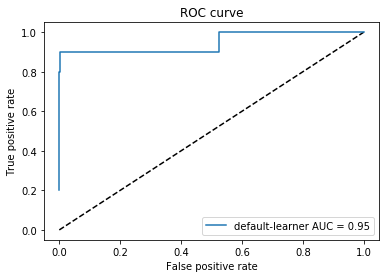

[[4988    2]
 [   3    7]]


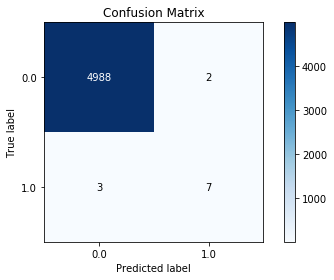

In [ ]:
generate_metrics(defaults_predictor, test_features[:5000], test_labels[:5000], 'default-learner')

In [ ]:
generate_metrics(class_weights_predictor, test_features[:5000], test_labels[:5000], 'class-weight-learner')

The visualizations above quickly show that the class weight linear model trades off precision for recall, but yields a higher number of true fraudulent cases at the expense of a few more false positives. 

This also shows that single metrics such as accuracy or F1 score or a confusin matrix etc may not be the best way to think about data science problems, particularly ones with high class imbalance. 

<h3> Feature Importance

Next, we discuss how to extract feature importances for models using Sagemaker. Depending on the model type, the approaches for extracting feature importances are different.
Example:- Linear learner is an MxNet model and xgBoost requires obtaining the Booster for the model. We illustrate both these approaches here.

For linear learner, the feature weights directly give the importance of the features.

For tree based models, visualizing the tree is super useful, as the top of the tree is the most important feature. An

Another way to think of feature importances is to look at SHAP values (https://arxiv.org/abs/1705.07874).

What these authors have shown is that borrowing the idea from cooperative game theory, by training a simpler linear model which approximates the behavior of the complicated non parameteric model. This linear model approimates the relative importance of each feature by looking at the model accuracy with and without the feature included in the model. Typically computing this within a non linear, non parametric model would require retraining a number of different versions of the model. This is where the approximate linear model comes in -- this simplifies greatly the task of retaining complex models

In [ ]:
# Use SHAP values for tree based models
#!pip install shap 

In [ ]:
# Install MXNet if not using an Mxset notebook
#! pip install mxnet

In [48]:
import mxnet as mx

In [100]:
# supply the key and filename, and obtain the feature weights. 
key= 'sagemaker/DEMO-visualization/defaults/output/linear-learner-2019-05-21-16-52-33-735/output/model.tar.gz'
filename= 'model.tar.gz'#ends in /model.tar.gz in my case

boto3.Session().resource('s3').Bucket(bucket).download_file(key, filename)

In [101]:
os.system('tar -zxvf model.tar.gz')

0

In [102]:
os.system('unzip model_algo-1') 
# Load the mxnet module
mod = mx.module.Module.load("mx-mod", 0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/module/base_module.py:56: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
	out_label
  warnings.warn(msg)


In [103]:
def feature_weights_ll(model, feature_names):
    """Given a linear learner model, plot the feature weights
    Arguments: 
    model: linear learner model extracted from s3 using steps above
    feature_names: list of feature names
    
    Result: Plot showing feature weights from high to low 
    """
    weights = np.abs(mod._arg_params['fc0_weight'].asnumpy().flatten())
    weights_idx = np.argsort(weights)[::-1]
    plt.figure(figsize = (10, 10))    
    plt.title('Feature Importances')
    plt.barh(range(len(weights_idx)), weights[weights_idx], color='b', align='center')
    plt.yticks(range(len(weights_idx)), [feature_names[i] for i in weights_idx])
    plt.xlabel('Relative Importance')
    plt.show()

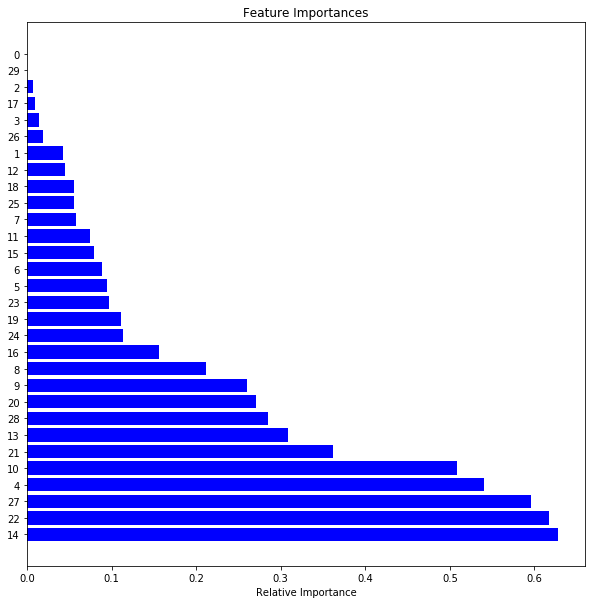

In [104]:
feature_weights_ll(mod, np.arange(test_features.shape[1]))

<h3> Feature Importance for XGBoost

For a model trained in Sagemaker, follow the same steps to create a Booster object and unzip the model tar in the notebook. Then extract the model tree to get a visual sense of the parameters and also plot the SHAP values

In [44]:
unzipped_model = 'visualization-xgboost-model'

booster = xgb.Booster()
booster.load_model(unzipped_model)

In [75]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [91]:
def my_plot_tree(booster, figsize, num_trees, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_tree
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_tree(booster=booster, num_trees=num_trees, ax= ax, **kwargs)

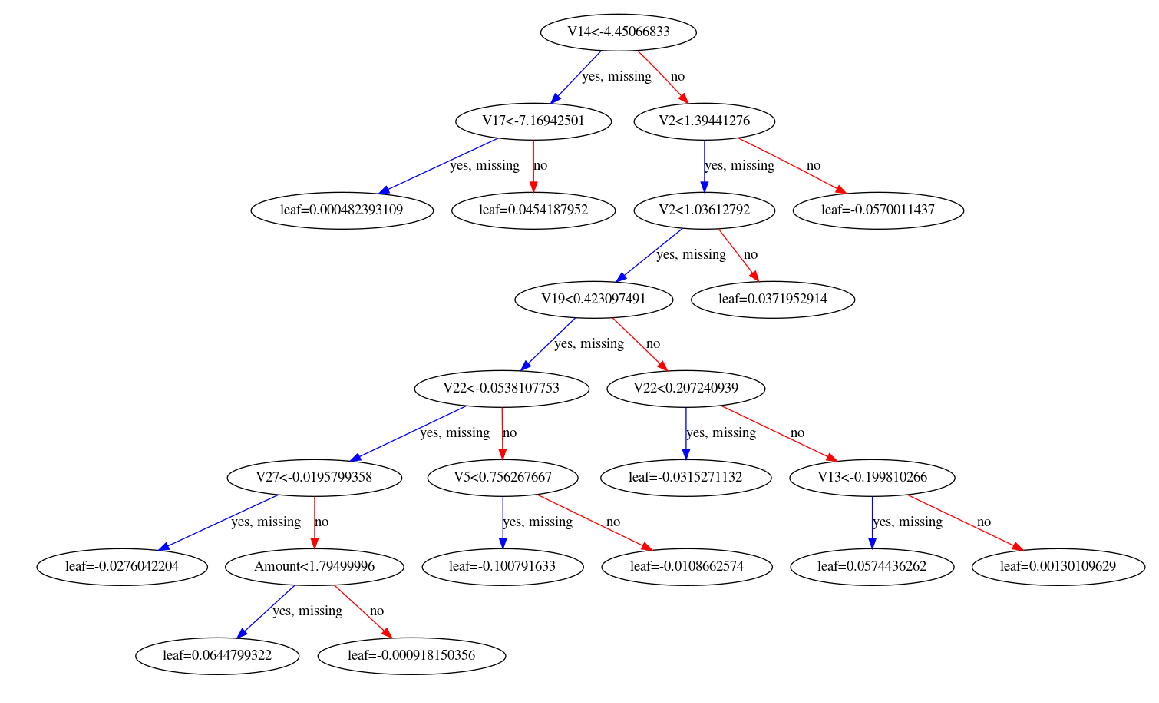

In [92]:
my_plot_tree(bt._Booster, (20, 20), 90)

In [73]:
import shap
shap_values = shap.TreeExplainer(bt).shap_values(train_data)

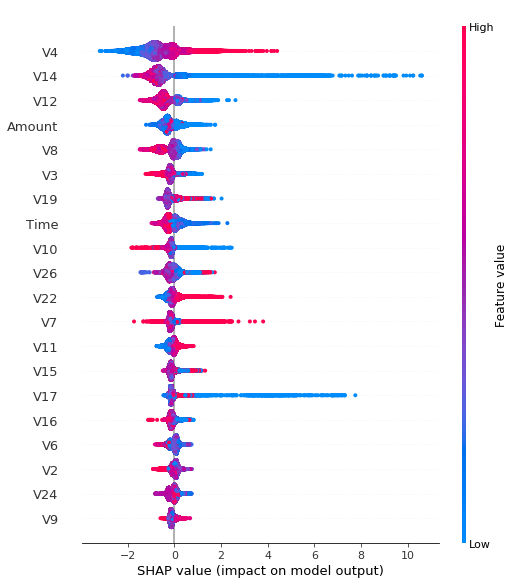

In [74]:
shap.summary_plot(shap_values, train_data)